In [1]:
import pandas as pd
import gensim
import re
import nltk
import numpy as np
import matplotlib.pyplot as plt
from itertools import chain

In [2]:
# preprocessing
df = pd.read_excel('Glossary.xls')
eng_df = df[df['language'] == 'eng']
eng_df.head()

,language,subject_id,keyword,simplified_definition,detail_definition
1,eng,0,BoP account,NaN,A BoP account is a statistical statement that ...
3,eng,0,"CPI(A), CPI(B), CPI(C) and Composite CPI",NaN,The Composite CPI reflects the impact of consu...
5,eng,0,Death,NaN,A death refers to the permanent disappearance ...
7,eng,0,Domestic household,NaN,Consist of a group of persons who live togethe...
9,eng,0,Employed persons,NaN,Refer to those persons aged >=15 who have been...


In [3]:
all_text = eng_df['detail_definition'].drop_duplicates()
all_text[:5]

1    A BoP account is a statistical statement that ...
3    The Composite CPI reflects the impact of consu...
5    A death refers to the permanent disappearance ...
7    Consist of a group of persons who live togethe...
9    Refer to those persons aged >=15 who have been...
Name: detail_definition, dtype: object

In [4]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Toby\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [5]:
lemmatizer = nltk.stem.WordNetLemmatizer()
# Define a function to perform both stemming and tokenization
def tokenize(text):
    tokens = nltk.word_tokenize(text)
    # Filter out raw tokens to remove noise
    filtered_tokens = [lemmatizer.lemmatize(token.lower()) for token in tokens if re.search('[a-zA-Z]', token)]
    
    # Stem the filtered_tokens
    stems = list(chain.from_iterable(word.split('/') for word in filtered_tokens))
    
    return filtered_tokens

In [6]:
tokenized_corpus = [tokenize(entry) for entry in all_text]
tokenized_corpus[5]

['export',
 'of',
 'service',
 'are',
 'the',
 'sale',
 'of',
 'service',
 'to',
 'the',
 'rest',
 'of',
 'the',
 'world']

In [7]:
from gensim.models import word2vec
# Set values for various parameters
feature_size = 100    # Word vector dimensionality  
window_context = 30          # Context window size                                                                                    
min_word_count = 1   # Minimum word count                        
sample = 1e-3   # Downsample setting for frequent words

w2v_model = word2vec.Word2Vec(tokenized_corpus, size=feature_size, 
                          window=window_context, min_count=min_word_count,
                          sample=sample, iter=50)

In [8]:
# view similar words based on gensim's model
similar_words = {search_term: [item[0] for item in w2v_model.wv.most_similar([search_term], topn=5)]
                  for search_term in ['index', 'population', 'employee', 'service']}
similar_words

{'index': ['obtained', 'volume', 'continuous', 'chain', 'aggregate'],
 'population': ['force', 'serf', 'by-censuses', 'census', 'thirty'],
 'employee': ['salary', 'wage', 'compensation', 'employment', 'mandatory'],
 'service': ['agency', 'support', 'trade-related', 'scientific', 'vii']}

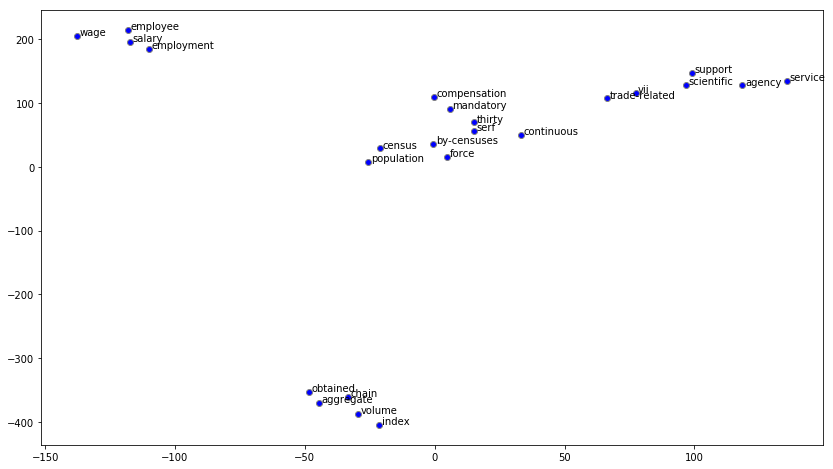

In [9]:
from sklearn.manifold import TSNE

words = sum([[k] + v for k, v in similar_words.items()], [])
# words = w2v_model.wv.index2word
wvs = w2v_model.wv[words]

tsne = TSNE(n_components=2, random_state=0, n_iter=10000, perplexity=2)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)
labels = words

plt.figure(figsize=(14, 8))
plt.scatter(T[:, 0], T[:, 1], c='blue', edgecolors='grey')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

In [10]:
#similarity
w2v_model.wv.similarity('index', 'volume')

0.8732481